<a href="https://colab.research.google.com/github/martinkenas/Client_Activity_Analysis/blob/main/Vartotoju_elgsenos_prognozavimas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install dataprep

In [34]:
from dataprep.eda import plot, plot_correlation, create_report

# Duomenų įkėlimas
df = pd.read_csv('/content/drive/MyDrive/marketing_campaign.csv', sep='\t')

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Duomenų įkėlimas
df = pd.read_csv('/content/drive/MyDrive/marketing_campaign.csv', sep='\t')

# Amžiaus skaičiavimas
df['Age'] = 2024 - df['Year_Birth']


Pirmieji duomenys:
| ID   | Year_Birth   | Education   | Marital_Status   | Income   | Kidhome   | Teenhome   | Dt_Customer   | Recency   | MntWines   | MntFruits   | MntMeatProducts   | MntFishProducts   | MntSweetProducts   | MntGoldProds   | NumDealsPurchases   | NumWebPurchases   | NumCatalogPurchases   | NumStorePurchases   | NumWebVisitsMonth   | AcceptedCmp3   | AcceptedCmp4   | AcceptedCmp5   | AcceptedCmp1   | AcceptedCmp2   | Complain   | Z_CostContact   | Z_Revenue   | Response   | Age   |
|:-----|:-------------|:------------|:-----------------|:---------|:----------|:-----------|:--------------|:----------|:-----------|:------------|:------------------|:------------------|:-------------------|:---------------|:--------------------|:------------------|:----------------------|:--------------------|:--------------------|:---------------|:---------------|:---------------|:---------------|:---------------|:-----------|:----------------|:------------|:-----------|:------|
| 5524 

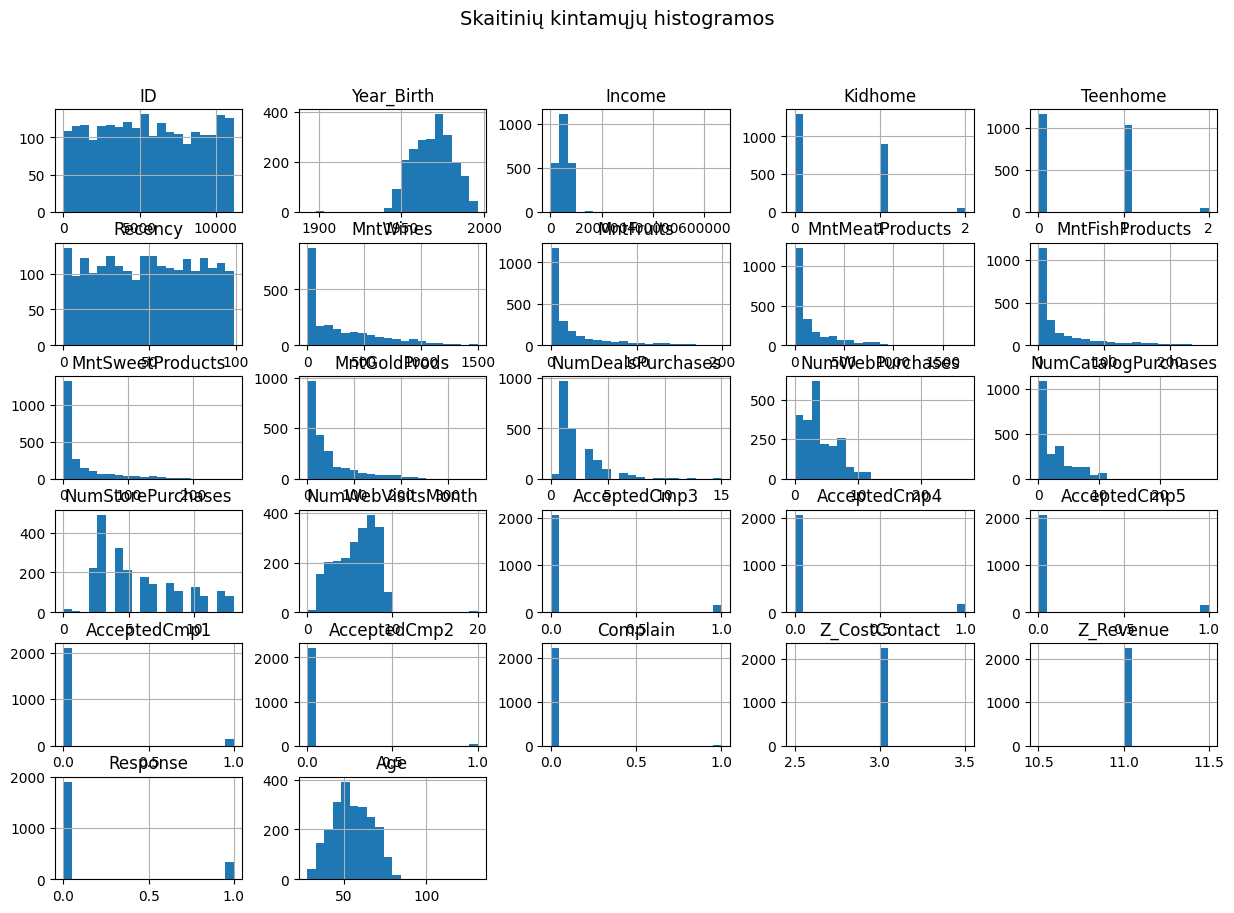

<ipython-input-36-e1959e4d09e0>:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


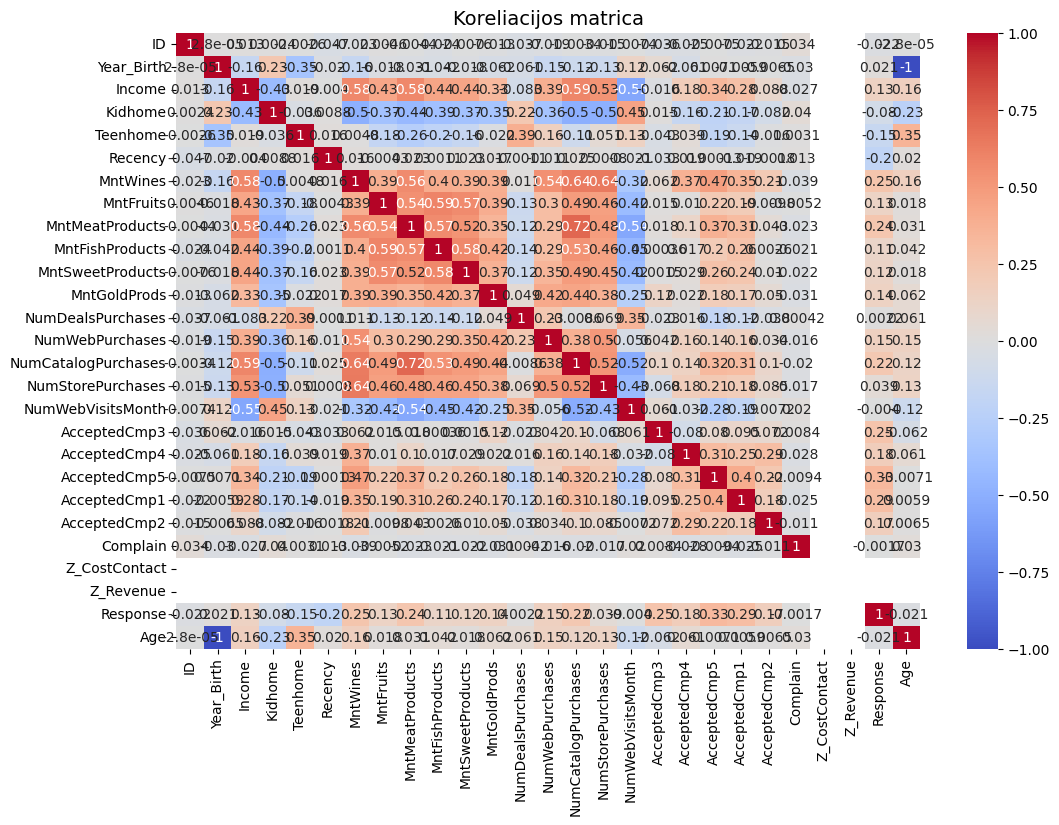

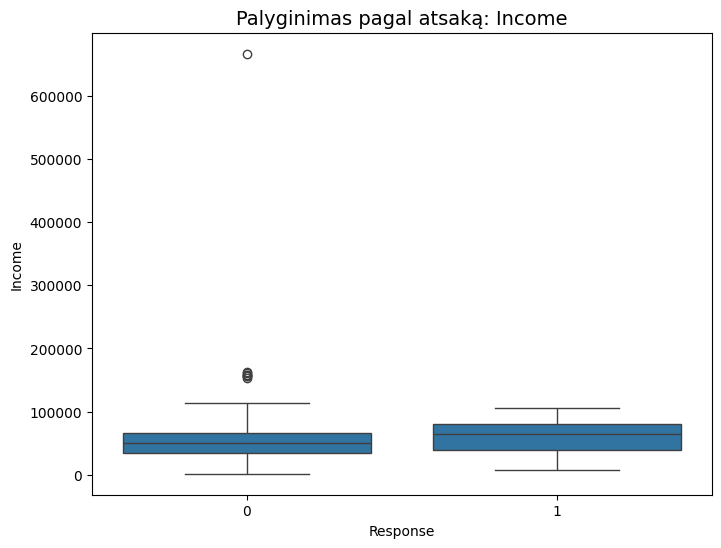

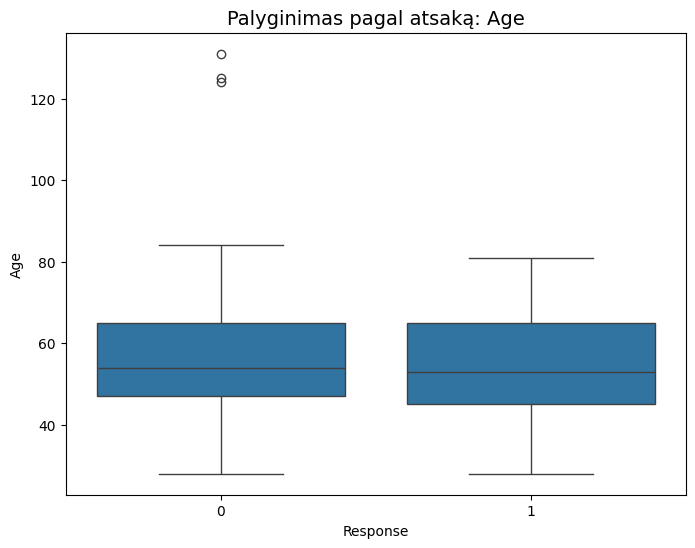

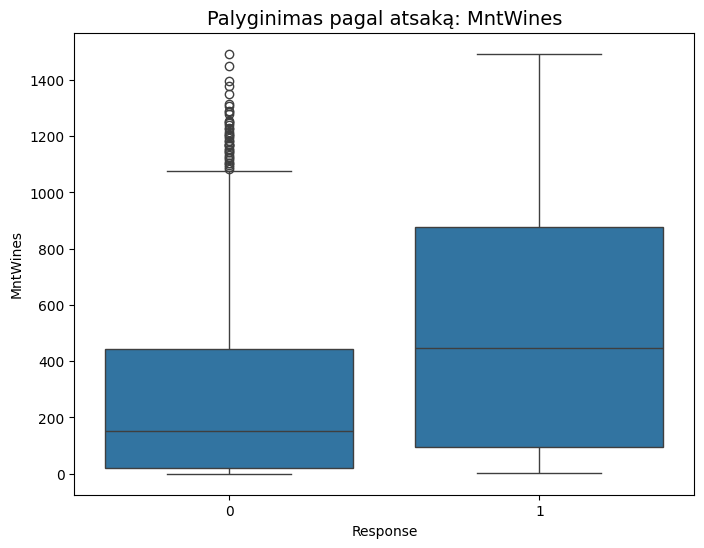

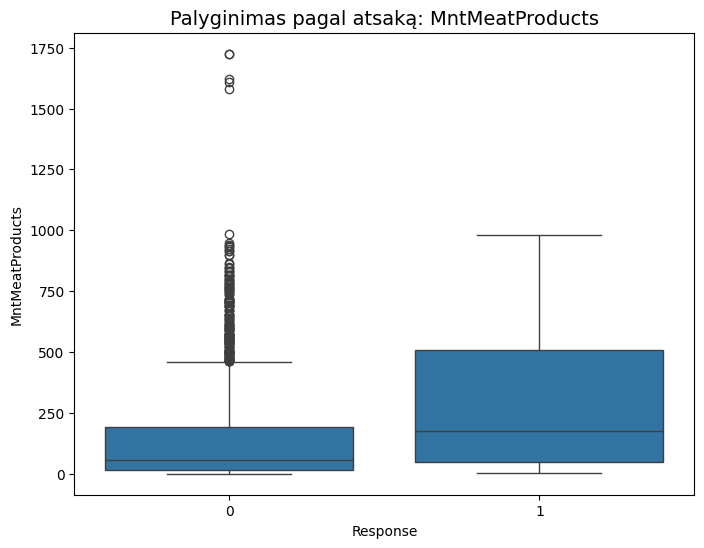


Dažnių lentelė: Education
| Education   | Dažnis   |
|:------------|:---------|
| Graduation  | 1127     |
| PhD         | 486      |
| Master      | 370      |
| 2n Cycle    | 203      |
| Basic       | 54       |

Dažnių lentelė: Marital_Status
| Marital_Status   | Dažnis   |
|:-----------------|:---------|
| Married          | 864      |
| Together         | 580      |
| Single           | 480      |
| Divorced         | 232      |
| Widow            | 77       |
| Alone            | 3        |
| Absurd           | 2        |
| YOLO             | 2        |


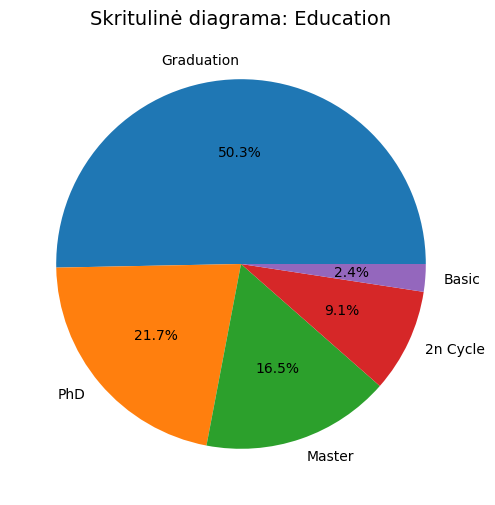

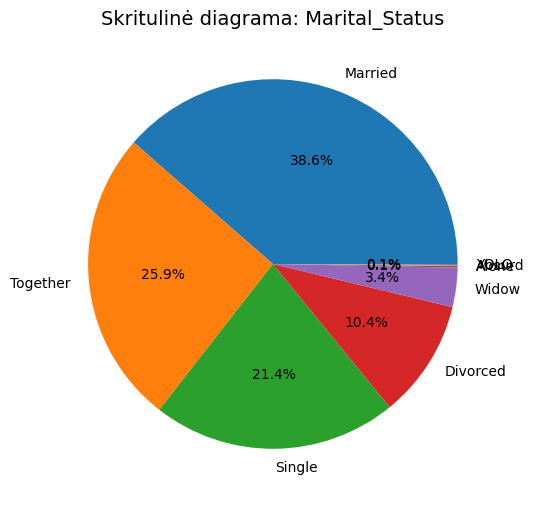

In [36]:
# 1. Duomenų peržiūra ir aprašomoji statistika
print("Pirmieji duomenys:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nDuomenų tipai ir trūkstamos reikšmės:")
print(df.info())

print("\nAprašomoji statistika:")
print(df.describe().to_markdown(numalign="left", stralign="left"))

# Skaičiuojame amžių, kadangi jo nėra duomenyse
df['Age'] = 2024 - df['Year_Birth']

# 2. Duomenų vizualizacija

# Histogramos skaitiniams kintamiesiems
df.hist(figsize=(15, 10), bins=20)
plt.suptitle('Skaitinių kintamųjų histogramos', fontsize=14)
plt.show()

# Koreliacijos matrica
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Koreliacijos matrica', fontsize=14)
plt.show()

# Dėžutės diagramos pagal atsaką ("Response")
for col in ['Income', 'Age', 'MntWines', 'MntMeatProducts']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Response', y=col, data=df)
    plt.title(f'Palyginimas pagal atsaką: {col}', fontsize=14)
    plt.show()

# 3. Kategorinių kintamųjų analizė

# Kategorinių kintamųjų dažnių lentelės
categorical_cols = ['Education', 'Marital_Status']
for col in categorical_cols:
    print(f'\nDažnių lentelė: {col}')
    print(df[col].value_counts().reset_index().rename(columns={'index': col, col: 'Dažnis'}).to_markdown(index=False, numalign="left", stralign="left"))

# Skritulinės diagramos
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Skritulinė diagrama: {col}', fontsize=14)
    plt.ylabel('')
    plt.show()



In [37]:
# Pažymų kūrimas pagal vyno išlaidas (3 kategorijos)
wine_discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['WineSpendingCategory'] = wine_discretizer.fit_transform(df[['MntWines']])

# Šeimos indikatoriaus sukūrimas (1 jei perka daugiau vaisių ir žuvies nei mediana, kitaip 0)
df['LikelyFamily'] = np.where((df['MntFruits'] > df['MntFruits'].median()) &
                             (df['MntFishProducts'] > df['MntFishProducts'].median()), 1, 0)

# Internetinio įsitraukimo skaičiavimas (dalis pirkimų internetu)
total_purchases = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
df['OnlineEngagement'] = df['NumWebPurchases'] / total_purchases
df['OnlineEngagement'].fillna(0, inplace=True)

# Požymiai ir tikslinis kintamasis
X = df.drop(['Response', 'Year_Birth', 'ID', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1)
y = df['Response']

# Duomenų padalijimas į mokymo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [38]:

# Modeliai ir parametrų paieška
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'), {'classifier__C': [0.001, 0.01, 0.1, 1, 10]}),  # Added "classifier__" prefix back
    'Random Forest': (RandomForestClassifier(random_state=42), {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 5, 10]}),
    'XGBoost': (XGBClassifier(random_state=42), {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]})
}


# Kryžminis patikrinimas
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, (model, param_grid) in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    results[name] = grid_search

    print(f"\n{name} (geriausi parametrai: {grid_search.best_params_}):")
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]):.4f}")

# ROC kreivių braižymas (nepakitęs)

# Geriausio modelio pasirinkimas ir galutinis įvertinimas
best_model_name = max(results, key=lambda name: results[name].best_score_)
best_pipeline = results[best_model_name].best_estimator_
print(f"\nGeriausias modelis: {best_model_name}")
y_pred = best_pipeline.predict(X_test)

# ... (Galutinio modelio įvertinimas - nepakitęs)



Logistic Regression (geriausi parametrai: {'classifier__C': 0.1}):
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       381
           1       0.45      0.79      0.57        67

    accuracy                           0.82       448
   macro avg       0.70      0.81      0.73       448
weighted avg       0.88      0.82      0.84       448

AUC-ROC: 0.9029

Random Forest (geriausi parametrai: {'classifier__max_depth': None, 'classifier__n_estimators': 200}):
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       381
           1       0.91      0.30      0.45        67

    accuracy                           0.89       448
   macro avg       0.90      0.65      0.69       448
weighted avg       0.89      0.89      0.87       448

AUC-ROC: 0.8746

XGBoost (geriausi parametrai: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}):
              precision    recall  f1-sco


Geriausias modelis: XGBoost


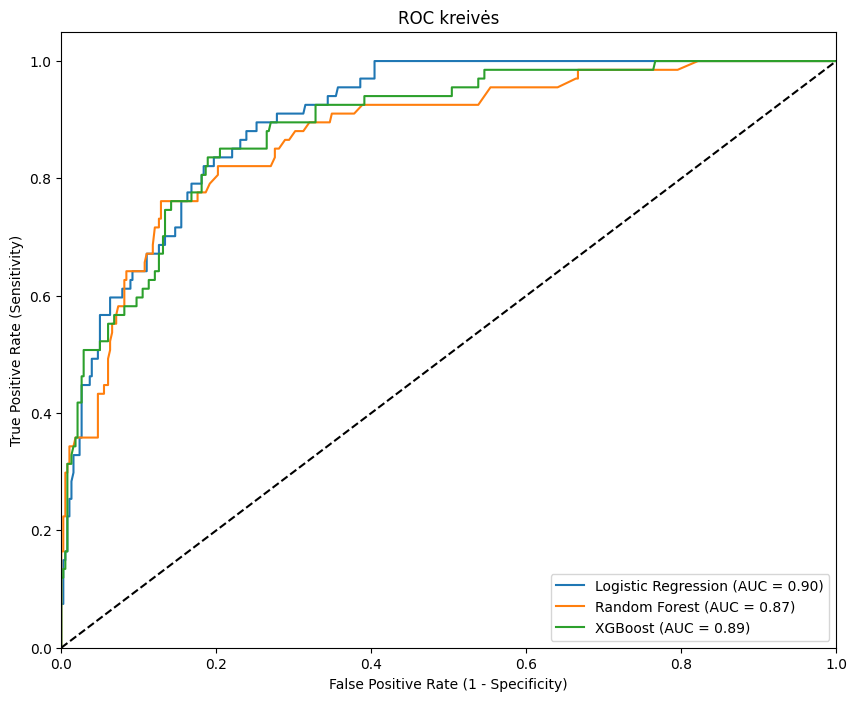


Galutinio modelio (XGBoost) įvertinimas:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       381
           1       0.76      0.37      0.50        67

    accuracy                           0.89       448
   macro avg       0.83      0.68      0.72       448
weighted avg       0.88      0.89      0.87       448

AUC-ROC: 0.8879


In [39]:
# Geriausio modelio pasirinkimas (pagal AUC-ROC)
best_model_name = max(results, key=lambda name: results[name].best_score_)
best_pipeline = results[best_model_name].best_estimator_

print(f"\nGeriausias modelis: {best_model_name}")

# ROC kreivių braižymas
plt.figure(figsize=(10, 8))
for name, result in results.items():
    y_prob = result.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Atsitiktinio spėjimo linija
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC kreivės')
plt.legend(loc="lower right")
plt.show()


# Galutinio modelio įvertinimas
y_pred = best_pipeline.predict(X_test)
print(f"\nGalutinio modelio ({best_model_name}) įvertinimas:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1]):.4f}")

